# Beginner's tutorial on molecular dynamics simulations in Gromacs
In this tutorial we will make a short MD simulation of a protein domain, named [chromo domain](https://en.wikipedia.org/wiki/Chromodomain) and make basic MD trajectory analysis.

For full Gromacs manual, see here http://manual.gromacs.org

## Step 1: Getting, examining and prepairing the PDB file.
The [protein data bank](https://www.rcsb.org) is a repository of protein structure files resolved via different experimental methods (X-ray, NMR, cryoEM, etc.).
Each structure is identified by a 4-letter PDB code.
[1Q3L](https://www.rcsb.org/structure/1Q3L) - is the structure named "Chromodomain Of HP1 Complexed With Histone H3 Tail Containing monomethyllysine 9", click to examine the page.
The PDB file can be downloaded from that page via this link https://files.rcsb.org/view/1Q3L.pdb .

In [1]:
#We will download this file via a terminal command, here
!wget https://files.rcsb.org/view/1Q3L.pdb

--2019-01-08 18:58:27--  https://files.rcsb.org/view/1Q3L.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.244.231
Connecting to files.rcsb.org (files.rcsb.org)|128.6.244.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘1Q3L.pdb’

1Q3L.pdb                [  <=>               ]  78.94K   321KB/s    in 0.2s    

2019-01-08 18:58:28 (321 KB/s) - ‘1Q3L.pdb’ saved [80838]



You can open this file and examine its contents. The main data section of the file is contained in lines that start with ATOM keyword, followed by atom number, atom name, residue name, chain name, residue number, x y z coordinates, occupance and B-factor.
Let's have a look:

In [75]:
!grep '^ATOM' 1Q3L.pdb | head -n 10

ATOM      1  N   GLU A  23       3.357  14.154   7.439  1.00 35.84           N  
ATOM      2  CA  GLU A  23       4.577  13.722   8.145  1.00 35.17           C  
ATOM      3  C   GLU A  23       4.416  12.424   8.920  1.00 32.22           C  
ATOM      4  O   GLU A  23       5.255  12.130   9.740  1.00 33.08           O  
ATOM      5  CB  GLU A  23       5.047  14.791   9.128  1.00 36.33           C  
ATOM      6  CG  GLU A  23       5.296  16.169   8.558  1.00 40.82           C  
ATOM      7  CD  GLU A  23       5.540  17.200   9.647  1.00 43.10           C  
ATOM      8  OE1 GLU A  23       5.385  18.412   9.356  1.00 47.25           O  
ATOM      9  OE2 GLU A  23       5.888  16.799  10.790  1.00 45.94           O  
ATOM     10  N   TYR A  24       3.332  11.663   8.702  1.00 28.90           N  
grep: write error: Broken pipe


Note, that PDB files usually lack hydrogen atoms.
We will now use a viewer to look at the structure in 3D. Use mouse to navigate and view the structure. Look at protein side chains, find oxygens of water molecules.

In [76]:
import nglview as nv
a=nv.show_structure_file('1Q3L.pdb')
a.add_representation('licorice')
a

NGLWidget()

We will use MDanalysis library to extract only chain A from the PDB file

In [77]:
import MDAnalysis as mda
pdb=mda.Universe("1Q3L.pdb")
sys=pdb.select_atoms("segid A")

pdb.trajectory.remarks=[]
pdb.trajectory.compound=[]
pdb.trajectory.header=['Chromodomain']

sys.write("sys.pdb")

## Step 2. Create simulation system and its topology.
- We need to do the following things:
   + Solvate our protein in a box with water and ions.
   + Create a physics model of the system for simulations based on a forcefield. This will require the generation of the so-called topology of the molecules, that describes atoms connectivity and atom types according to the forcefield.


Let's understand how the forcefields files are organized.
Gromacs ships with a number of forcefields alredy provided.
The folder containing forcefields can be located as follows, below we output its contents.

In [78]:
%%bash
source GMXRC
echo $GMXDATA/top
ls $GMXDATA/top

/opt/miniconda3/envs/moldyn/share/gromacs/top
amber03.ff
amber94.ff
amber96.ff
amber99.ff
amber99sb.ff
amber99sb-ildn.ff
amberGS.ff
atommass.dat
atom_nom.tbl
bonds.dlg
ca-shift.dat
cb-shift.dat
charmm27.ff
co-shift.dat
defselection.dat
dgsolv.dat
edissoc.dat
electroneg.dat
elements.dat
export.dlg
ffG43a1.itp
ffG43a2.itp
ffG45a3.itp
ffG53a5.itp
ffG53a6.itp
ffoplsaa.itp
ffoplsaa-n.tst
flexspce.itp
flexspc.itp
flexwat-ferguson.itp
gromos43a1.ff
gromos43a2.ff
gromos45a3.ff
gromos53a5.ff
gromos53a6.ff
gromos54a7.ff
ha-shift.dat
ions.itp
nsfactor.dat
oplsaa.ff
phbres.dat
ps.m2p
random.dat
README
refi_aa.dat
residues.dtd
residues.xml
residuetypes.dat
sfactor.dat
spc216.gro
spce.itp
spc.itp
specbond.dat
ss.map
surface.dat
sw.itp
table6-10.xvg
table6-11.xvg
table6-12.xvg
table6-8.xvg
table6-9.xvg
tip3p.itp
tip4p.gro
tip4p.itp
tip5p.gro
vdw-msms.dat
vdwradii.dat
xlateat.dat


We will use CHARMM27 forcefield, let's look inside the folder containing forcefield.

In [79]:
%%bash
source GMXRC
ls $GMXDATA/top/charmm27.ff

aminoacids.arn
aminoacids.c.tdb
aminoacids.hdb
aminoacids.n.tdb
aminoacids.r2b
aminoacids.rtp
aminoacids.vsd
atomtypes.atp
cmap.itp
dna.arn
dna.c.tdb
dna.hdb
dna.n.tdb
dna.rtp
ffbonded.itp
ffnabonded.itp
ffnanonbonded.itp
ffnonbonded.itp
forcefield.doc
forcefield.itp
gb.itp
ions.itp
lipids.hdb
lipids.rtp
rna.arn
rna.c.tdb
rna.hdb
rna.n.tdb
rna.r2b
rna.rtp
spce.itp
spc.itp
tip3p.itp
tip4p.itp
tip5p.itp
tips3p.itp
watermodels.dat


You can look into files using following snippet

In [80]:
%%bash
source GMXRC
#head -n 10 $GMXDATA/top/charmm27.ff/atomtypes.atp
#head -n 10 $GMXDATA/top/charmm27.ff/aminoacids.rtp
#head -n 10 $GMXDATA/top/charmm27.ff/ffbonded.itp
#head -n 10 $GMXDATA/top/charmm27.ff/ffnonbonded.itp
#head -n 30 $GMXDATA/top/charmm27.ff/forcefield.itp


Here is the description of key files:
 - atomtypes.atp - list of atom types in the forcefield. Atom types should not be confused with atom names in PDB. Atom types are connected to the forcefield parameters (van der Waals radii, interaction potentials, etc.). Every 
 - aminoacids.rtp - residue topology file, for amino acid residue defines 
      + the correspondence of PDB atom names in a specific residue to forcefield atom types
      + The topology, i.e. connectivity of atoms
      + Defines the partial charges on atoms.
      + Defines some additional topology parameters, such as improper angles, and forcefiled specific corrections.
 - ffbonded.itp - defines forcefield interaction functions and constants for bonded interactions between specific atom types, i.e. for bonds, angles, dihedral angles.
 - ffnonbonded.itp - defines forcefield constants for non-bonded interactions, e.g. Lennard-Johnes potential constants.
 - forcefield.itp - defines some general parameters of the forcefield (e.g. non-bonded interaction functions, mixing rules) and lists all other files that will be included in the forcefiled definition.

## Step 2.1. Generating initial topology file from the PDB file
- The topology file is used to describe the connectivity of atoms in the system, their types according to the forcefiled and the forcefield interaction parameters. I.e. topology file describes the exact physics model of the system to simulate.
- PDB2GMX command is a very helpful tool to create an initial topology file from the PDB file http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-pdb2gmx.html

In [81]:
!gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff charmm27

                     :-) GROMACS - gmx pdb2gmx, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

PDB2GMX will produce:
 - A new init.pdb file with hydrogen atoms added
 - A topol.top file - the topology file. Note: GROMACS uses a preprocessor and its syntax similar to C/C++ language. This gives the ability to 'include' certatin files within others and use 'define' variables to conditionally include certain files.
 - posre.itp - file, an axillary file which defines contraints on atom positions - useful during equlibration of the system.
Let's look at some files:

In [82]:
#!head -n 10 init.pdb
!head -n 40 topol.top
#!head -n 10 posre.itp



;
;	File 'topol.top' was generated
;	By user: unknown (1001)
;	On host: newton
;	At date: Wed Jan  9 01:15:59 2019
;
;	This is a standalone topology file
;
;	Created by:
;	                    :-) GROMACS - gmx pdb2gmx, 2018.3 (-:
;	
;	Executable:   /opt/miniconda3/envs/moldyn/bin/gmx
;	Data prefix:  /opt/miniconda3/envs/moldyn
;	Working dir:  /home/alexsha/projects/MolModEdu/GROMACS/beginner
;	Command line:
;	  gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff charmm27
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "charmm27.ff/forcefield.itp"

[ moleculetype ]
; Name            nrexcl
Protein_chain_A     3

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
; residue  23 GLU rtp GLU  q  0.0
     1        NH3     23    GLU      N      1       -0.3     14.007   ; qtot -0.3
     2         HC     23    GLU     H1      2       0.33      1.008   ; qtot 0.03
 

## Step 2.2. Solvating the molecule.
Next we will need to put our protein into a box of water

In [83]:
#First put a system in a periodic box, with 1 nm distance to the walls (-d), centered in the box (-c)
!gmx editconf -d 1 -c -f init.pdb -o init_box.pdb

                     :-) GROMACS - gmx editconf, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

In [84]:
#Look how the box vectors changed in the pdb-file
!head init.pdb
!head init_box.pdb

TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
REMARK    THIS IS A SIMULATION BOX
CRYST1   33.809   76.828   75.625  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1  N   GLU A  23       3.357  14.154   7.439  1.00  0.00           N
ATOM      2  H1  GLU A  23       3.538  15.010   6.954  1.00  0.00            
ATOM      3  H2  GLU A  23       3.085  13.450   6.783  1.00  0.00            
ATOM      4  H3  GLU A  23       2.621  14.295   8.101  1.00  0.00            
ATOM      5  CA  GLU A  23       4.577  13.722   8.145  1.00  0.00           C
ATOM      6  HA  GLU A  23       5.225  13.578   7.397  1.00  0.00            
TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
REMARK    THIS IS A SIMULATION BOX
CRYST1   47.727   50.811   53.311  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1  N   GLU A  23      34.573  29.898  28.814  1.00  0.00           N
ATOM      2  H1  GLU A  23      34.754  30.754  28.329  1.00  0.00           H
ATOM      3  H2  GLU A  

In [85]:
#Now to the solvation, note, the topology file will be updated to reflect the added water molecules.
!gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top

                     :-) GROMACS - gmx solvate, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [86]:
#Let's look at the protein in a water box.
import nglview as nv
a=nv.show_structure_file('init_solv.pdb')
a.add_representation('licorice')
a

NGLWidget()

## Step 2.3. Adding ions to the system
Next we will need to add ions in order to
- neutralize the system
- model the desired ionic strength in the cell, usually 150 mM NaCl is used for simulations.

Placing the ions at arbitrary positions is a bad idea due to potential creation of bad, high energy contacts.
So GROMACS, uses a special techinque to estimate the low energy positions and place ions there implemented in `genion` command.
This command, however, requires a .tpr file, a type of file, which is normally used to start an MD simulation run.
It's generation requires and .mdp file, which contains infromation about the simulation protocol.
We will generate this file with a simple ions.mpd file.
And then execute the `genion` command.


In [87]:
!gmx grompp -f ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

And now run genions http://manual.gromacs.org/documentation/current/onlinehelp/gmx-genion.html

In [88]:
%%bash
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -conc 0.150 -neutral <<!
SOL
!

Will try to add 15 NA ions and 12 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 27 solute molecules in topology file (topol.top)  by 15 NA and 12 CL ions.


                      :-) GROMACS - gmx genion, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [89]:
#Let's look at the protein in a water box with ions.
import nglview as nv
a=nv.show_structure_file('init_solv_ions.pdb')
a.add_representation('licorice')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a

NGLWidget()

## Step 3. Subject system to energy minimization. 
- The system in its initial state likely is not well equilibrated, there are many atom clashes. These will cause the system to explode if we were to start MD simulations right away.
- The initial preparaiton of an equilibrated state of the system is important and should be done carefully.
- The first step is to minimize the energy of the system with respect to atom coordinates to remove atom clashes. 

To make a simulation or minimization in Gromacs one has to define an .mdp file.
These has all the similation protocol parameters.
We provide one here, let's have a look

In [90]:
!head -n 30 minim.mdp

;MDP-file for minimization in amber forcefield

; VARIOUS PREPROCESSING OPTIONS
include                  = 
define                   = -DPOSRES ; will trigger the inclusion of posre.itp into your topology, used for implementing position restraints.


; RUN CONTROL PARAMETERS
integrator               = steep ; Steepest descent integrator
nsteps                   = 1000 ; 10000 steps
init-step                = 0 ; For exact run continuation or redoing part of a run
simulation-part          = 1 ; Part index is updated automatically on checkpointing (keeps files separate)
comm-mode                = Linear ; mode for center of mass motion removal

nstcomm                  = 100 ; number of steps for center of mass motion removal
comm-grps                =  System ; group(s) for center of mass motion removal default is the whole system;

dt                      = 0.002 ; this is only for MD

; ENERGY MINIMIZATION OPTIONS
; Force tolerance and initial step-size
emtol                    = 100.

The `grompp` comand packs topology together with mdp file into a .tpr file - the sole file needed to start minimization/simulation.
See details here http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html

In [93]:
!gmx grompp -f minim.mdp -c init_solv_ions.pdb -p topol.top -o minim.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Now let's run the minimization, this may take a while ...

In [94]:
!gmx mdrun -nt 2 -deffnm minim # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [97]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','minim.trr')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

NGLWidget(count=8)

Last Frame read : 792, time : 1000.0 ps
792 frame read in 0.12 seconds


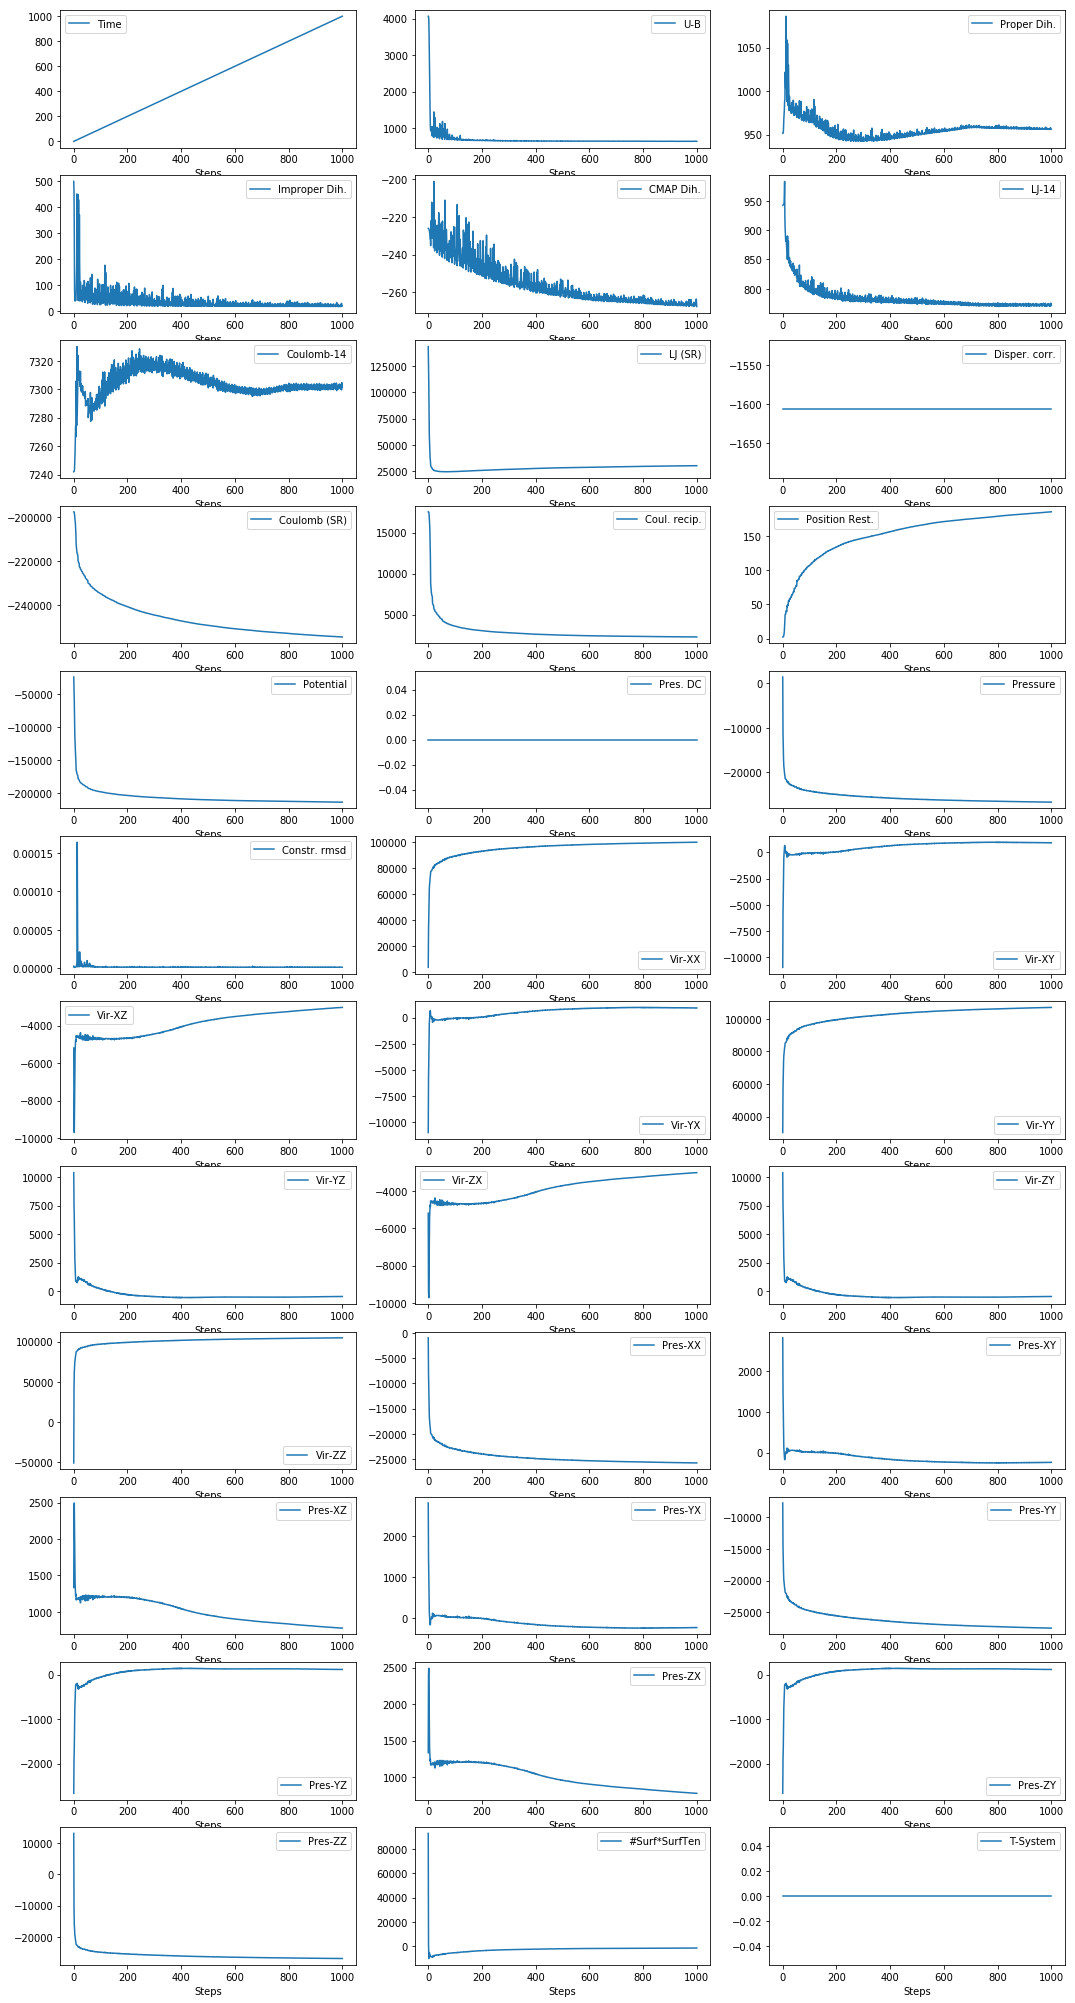

In [105]:
import panedr
import matplotlib.pyplot as plt
%matplotlib inline
df = panedr.edr_to_df('minim.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0::1],label=key)
    ax.set_xlabel('Steps')
    ax.legend()    
plt.show()

## Step 4. Subject system to equilibration. 
- This will be a short MD run with small timestep, positional restraints on protein atoms and increased temperature and pressure coupling.

In [99]:
!gmx grompp -f equil.mdp -c minim.gro -p topol.top -o equil.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [100]:
!gmx mdrun -nt 2 -deffnm equil # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [106]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','equil.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

NGLWidget(count=101)

Last Frame read : 101, time : 10.0 ps
101 frame read in 0.03 seconds


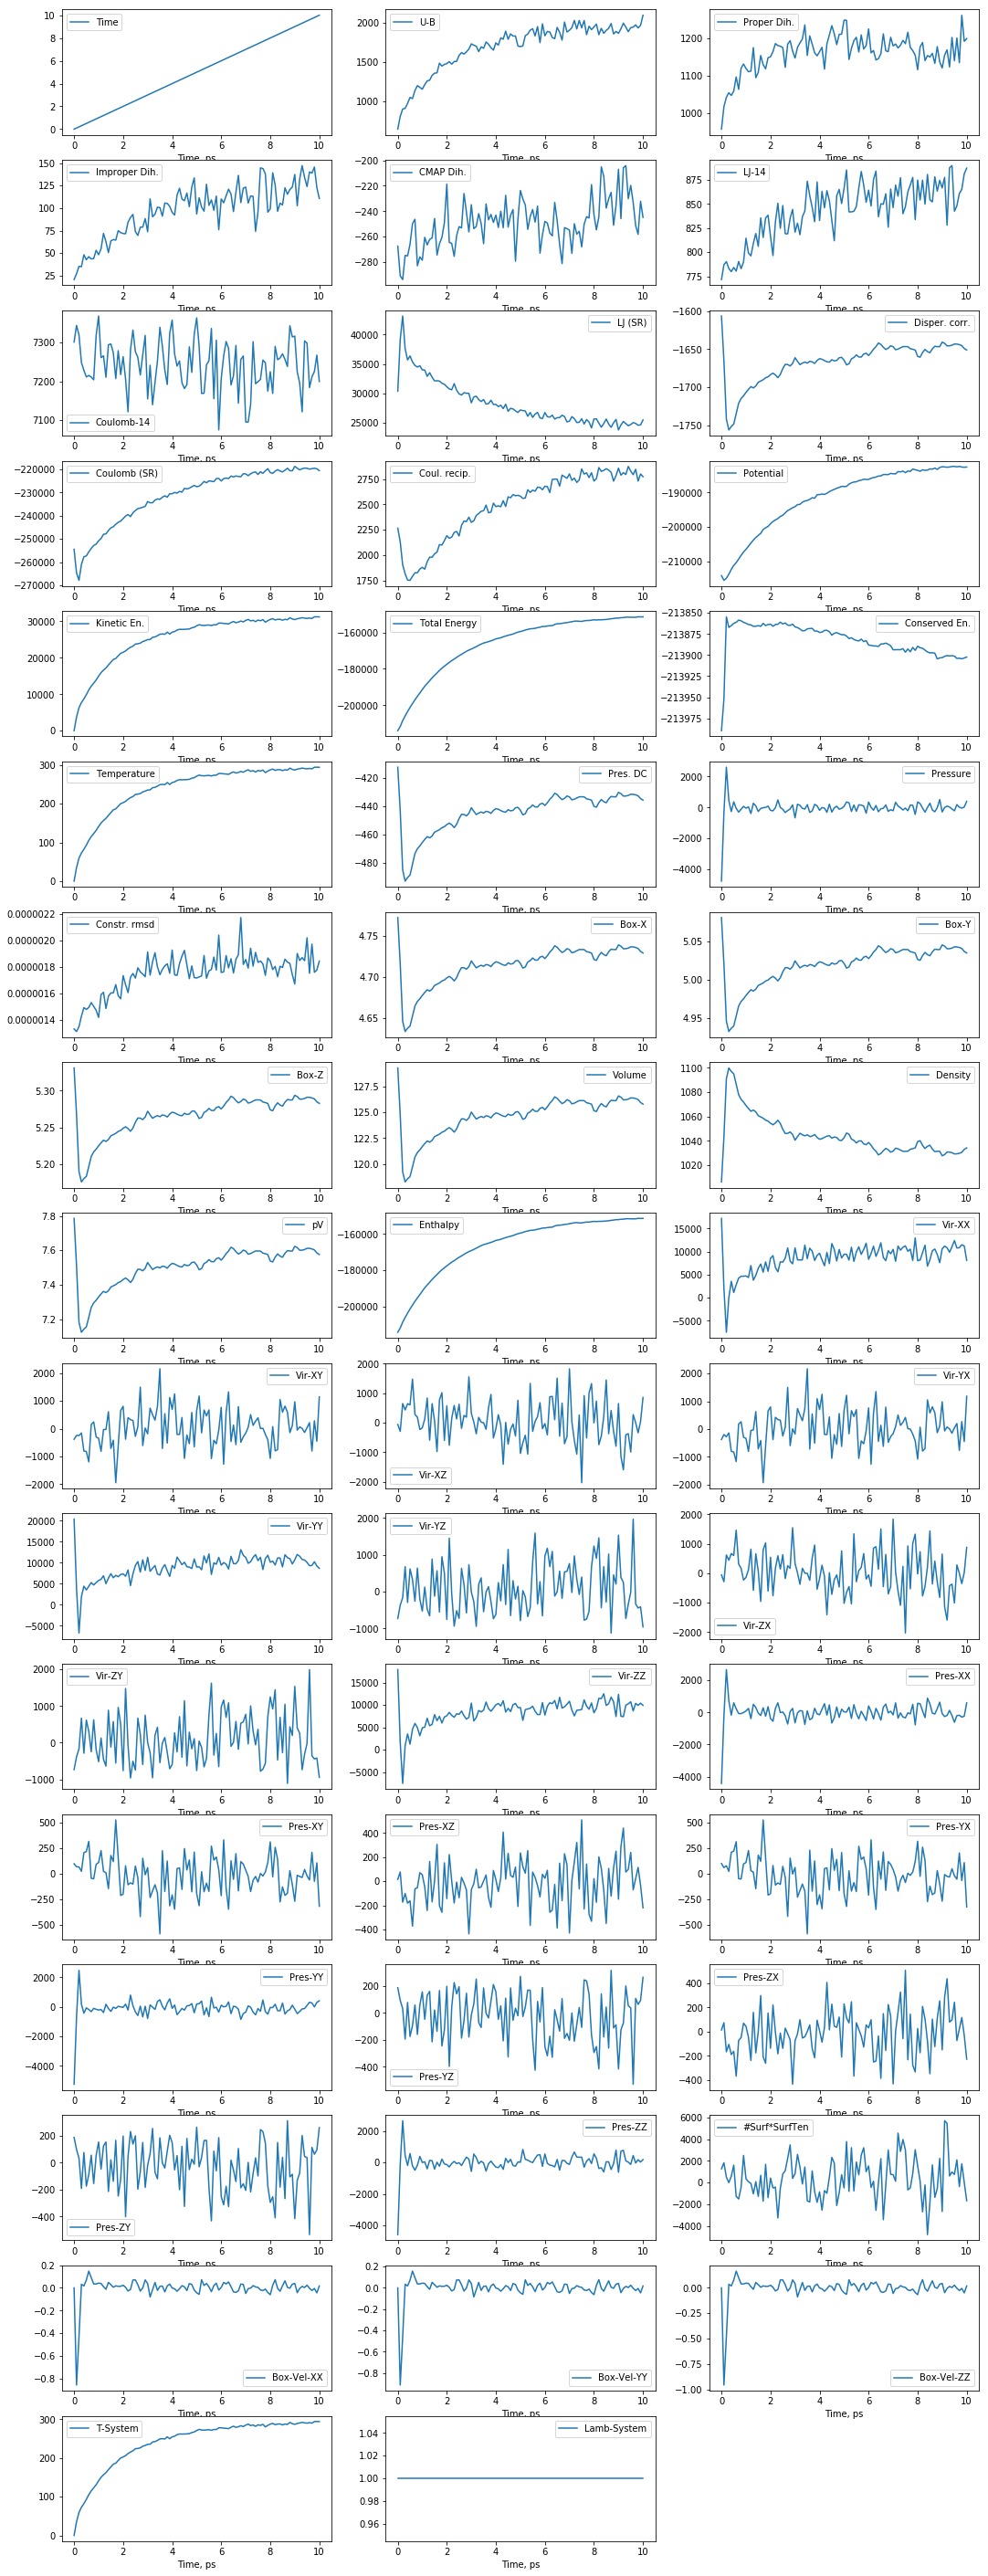

In [107]:
import panedr
import matplotlib.pyplot as plt
%matplotlib inline
df = panedr.edr_to_df('equil.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0::1],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

## Step 5. Production MD run. 
- This will be a main run, where we can finally analyze dynamics.

In [108]:
!gmx grompp -f prod.mdp -c equil.gro -p topol.top -o prod.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [109]:
!gmx mdrun -nt 20 -deffnm prod # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [110]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

NGLWidget(count=1001)

In [ ]:
import panedr
import matplotlib.pyplot as plt
%matplotlib inline
df = panedr.edr_to_df('prod.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0::1],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

Last Frame read : 5001, time : 1000.0 ps
5001 frame read in 0.77 seconds


## Step 6. Trajectory analysis.
